# Fitting Gaussian random field with missing modes

Would like to fit high lmax foregrounds using a model with a lower lmax = lmod.
This reduces the fidelity of our reconstruction. Let's test missing 
modes-modelling on a Gaussian random field with the same power spectrum as our
foregrounds.

In [1]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns


import src.plotting as PL
import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM

RS = SH.RealSphericalHarmonics()

3072 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


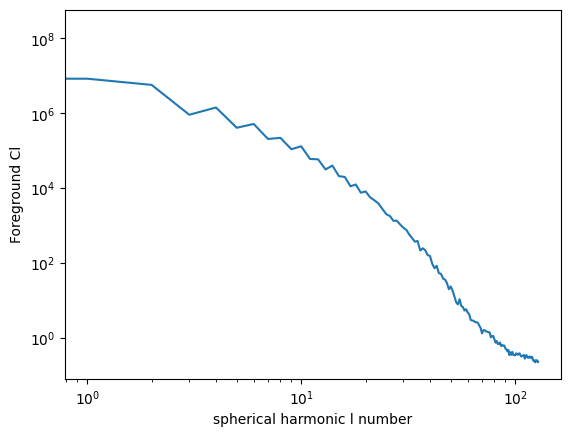

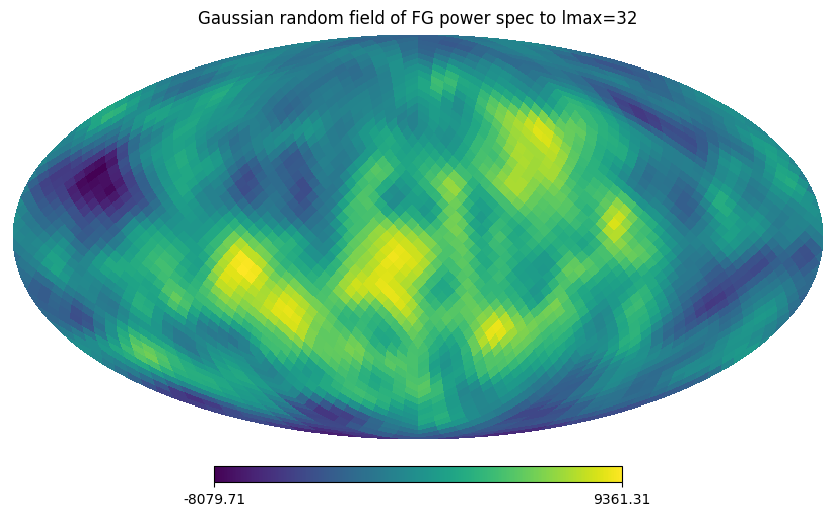

3072 561
Time taken to calculate:
G : 0.10491800308227539
Y : 16.424232959747314
B : 0.062272071838378906


In [2]:
lmax=32
nside=16
npix = hp.nside2npix(nside)
# Generate the ylm matrix for later.
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

# Generate foreground map.
fg_full_map = GlobalSkyModel2016(resolution='low').generate(60)
fg_cl = hp.sphtfunc.anafast(fg_full_map, lmax=64*2)
plt.loglog(fg_cl)
plt.xlabel("spherical harmonic l number")
plt.ylabel("Foreground Cl")
plt.show()

# Generate Gaussian field with the same Cl as the foreground map.
np.random.seed(124)
fg_gauss_map = hp.synfast(fg_cl, lmax=lmax, nside=nside)
hp.mollview(fg_gauss_map, title=f"Gaussian random field of FG power spec to lmax={lmax}")
plt.show()

# Convert Gaussian field to real alm.
fg_gauss_alm = hp.map2alm(fg_gauss_map, lmax=lmax)
fg_gauss_alm = RS.complex2RealALM(fg_gauss_alm)

# Observe the Gaussian random field.
narrow_cosbeam = lambda x : BF.beam_cos(x, theta0=0.8)
mat_A_fm = FM.calc_observation_matrix_all_pix(nside=nside, lmax=lmax, Ntau=npix, Nt=npix, beam_use=narrow_cosbeam)
d = mat_A_fm @ fg_gauss_alm

# Add noise.
d_noisy, noise_covar = SM.add_noise(d, 1, Ntau=npix, t_int=1e4, seed=124)

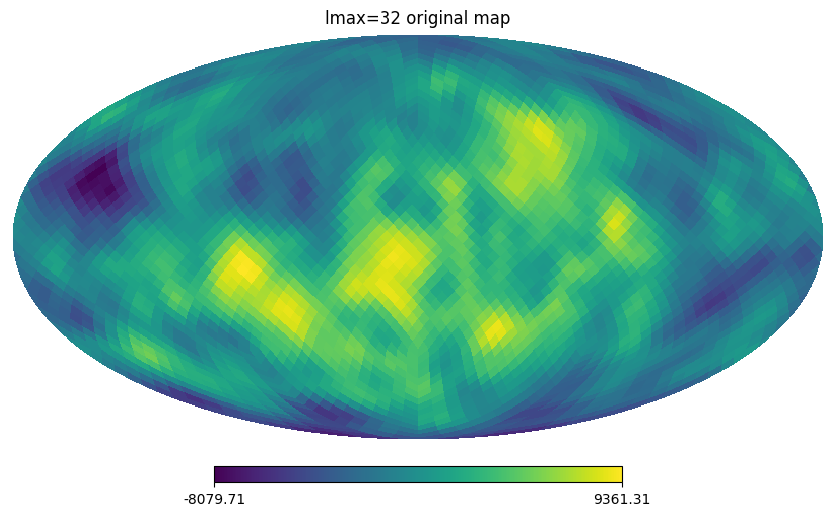

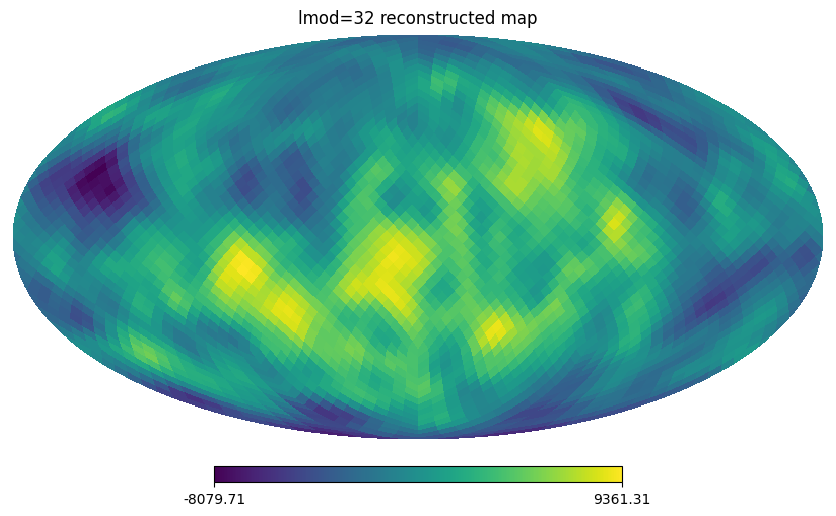

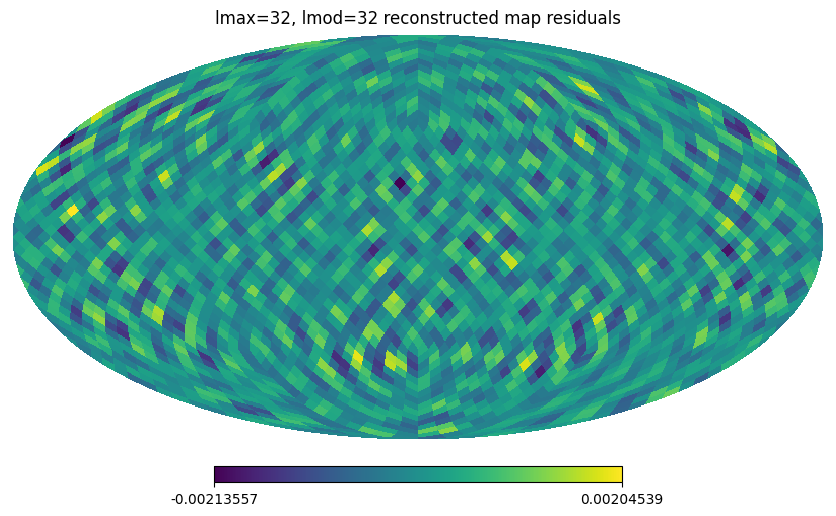

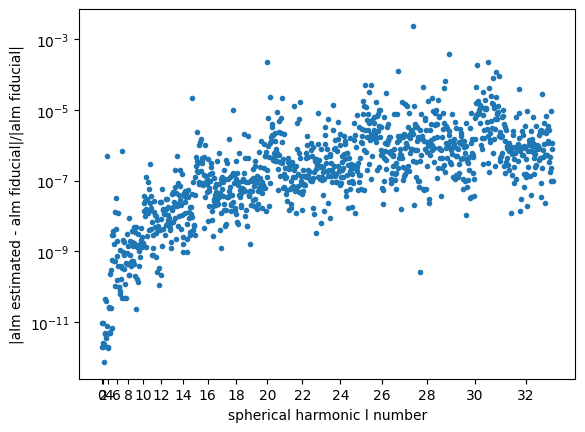

In [4]:
# First model the Gaussian random field perfectly.
mat_W_perfect = MM.calc_ml_estimator_matrix(mat_A=mat_A_fm, mat_N=noise_covar)
a_ml_noisefree = mat_W_perfect @ d
a_ml_noisy = mat_W_perfect @ d_noisy

# Noise free case.
PL.compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_noisefree, ylm_mat=ylm_mat)

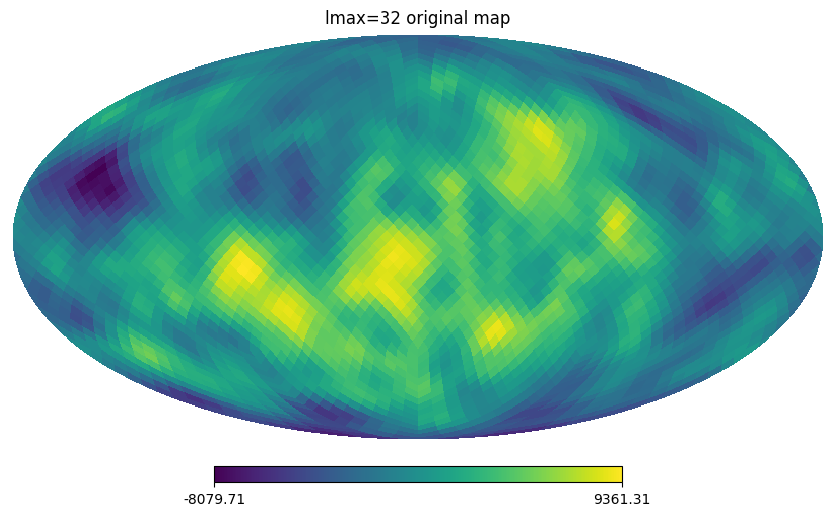

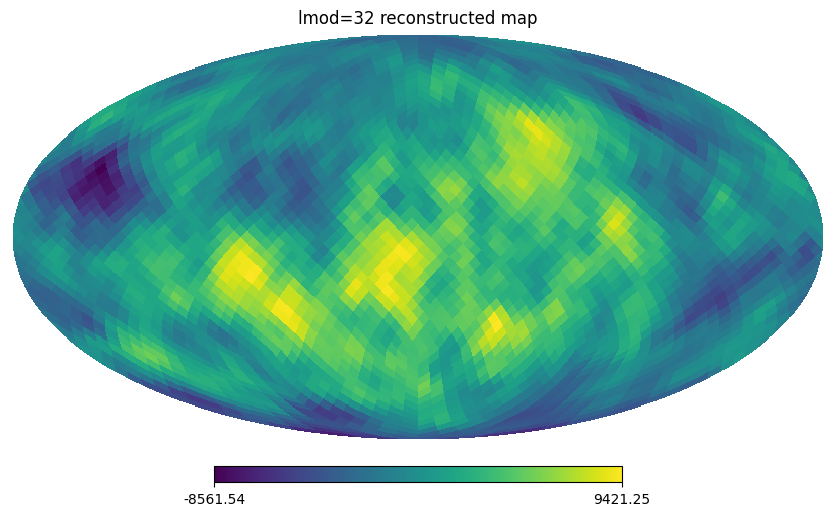

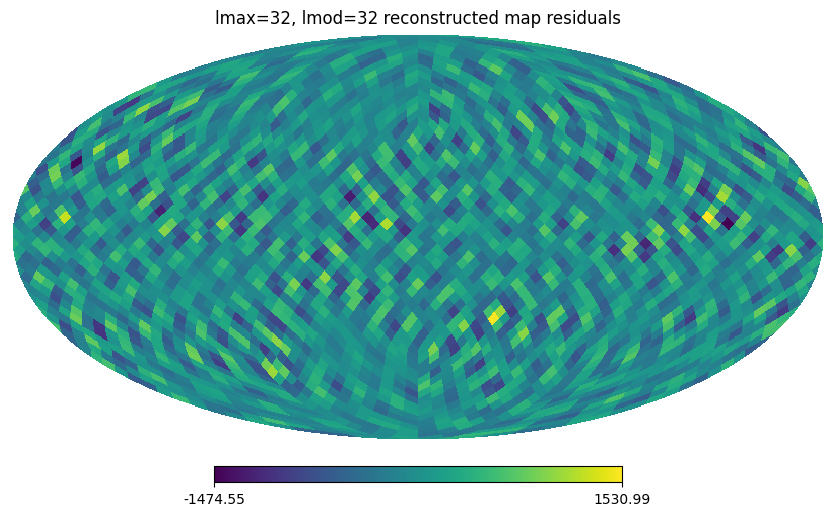

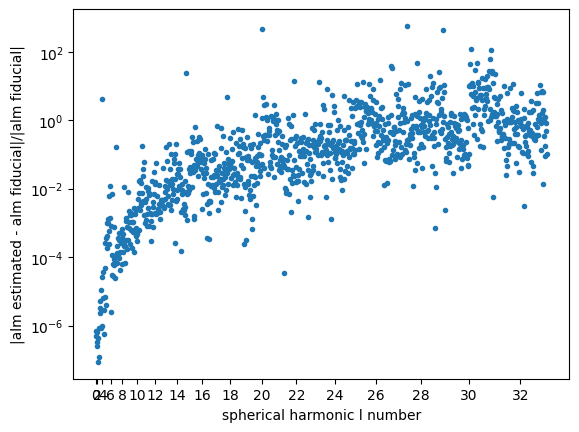

In [5]:
# Noisy case.
PL.compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_noisy, ylm_mat=ylm_mat)

3072 276
Time taken to calculate:
G : 0.1070249080657959
Y : 6.420804977416992
B : 0.1155080795288086


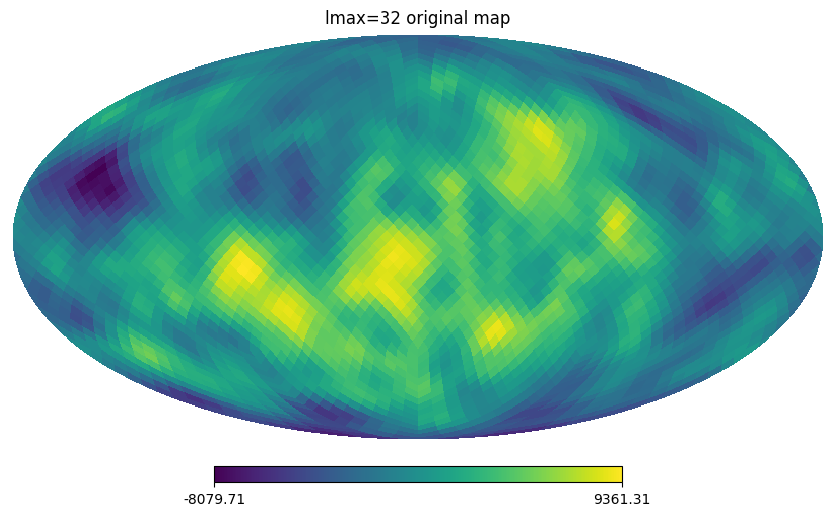

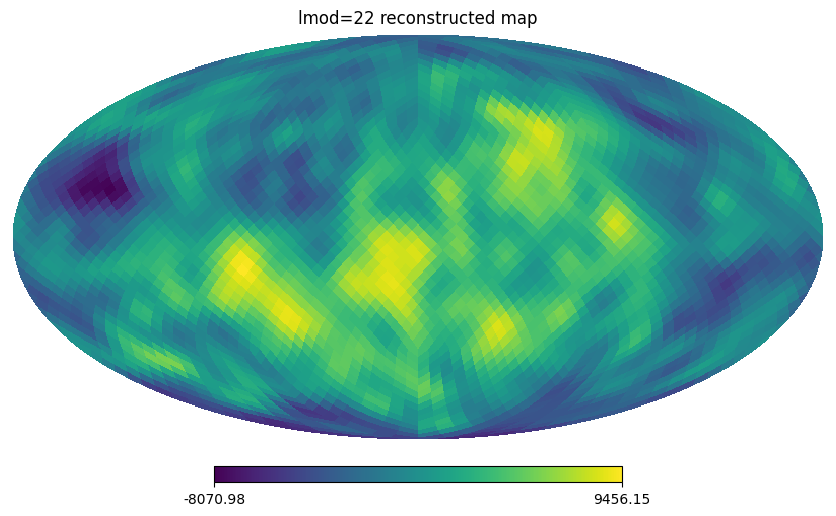

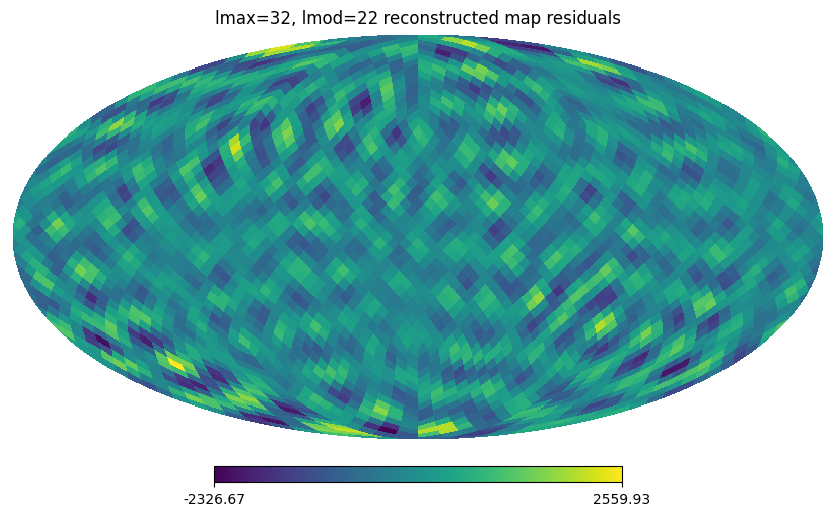

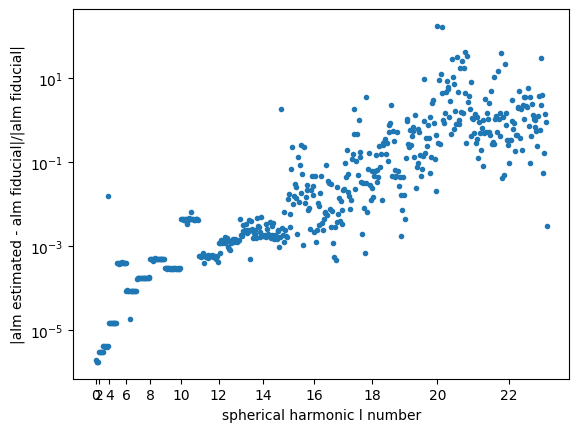

In [6]:
# Now model the field badly with missing modes.
lmod = 22
mat_A_lowl = FM.calc_observation_matrix_all_pix(nside=nside, lmax=lmod, 
                                                Ntau=npix, Nt=npix, 
                                                beam_use=narrow_cosbeam)
mat_W_lowl = MM.calc_ml_estimator_matrix(mat_A=mat_A_lowl, mat_N=noise_covar)
a_ml_lowl_noisefree = mat_W_lowl @ d
a_ml_lowl_noisy = mat_W_lowl @ d_noisy

# Noise free case
PL.compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_lowl_noisefree, ylm_mat=ylm_mat)

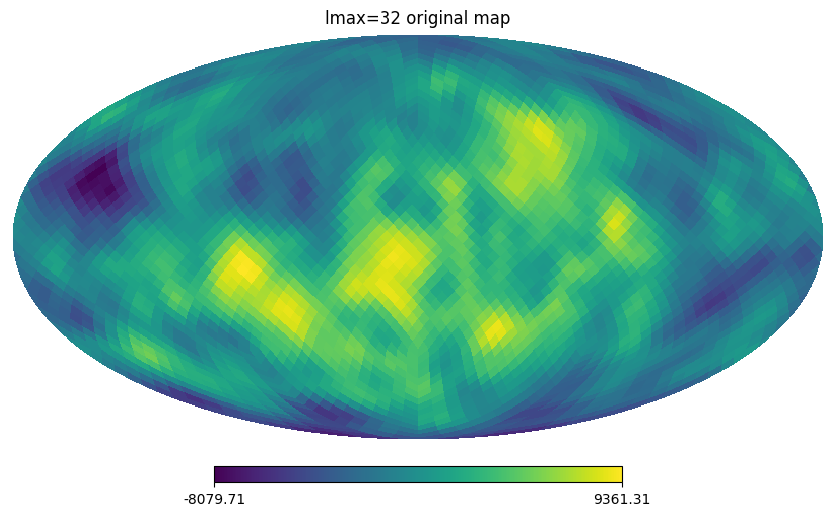

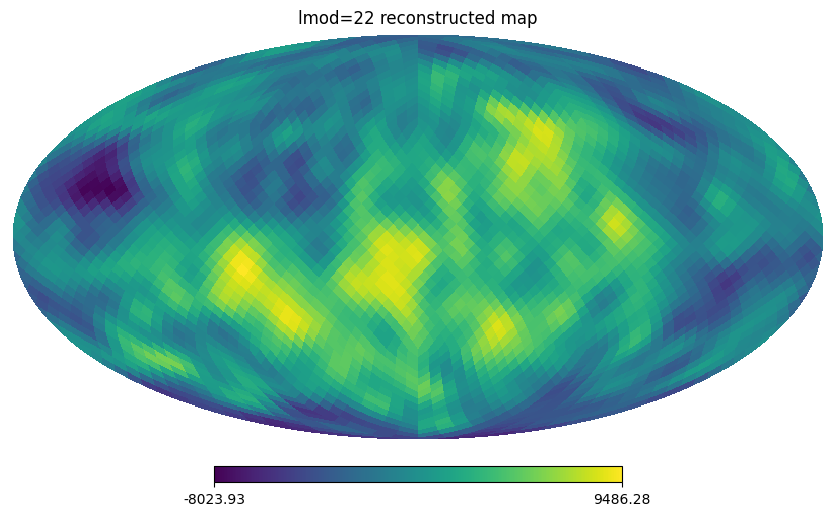

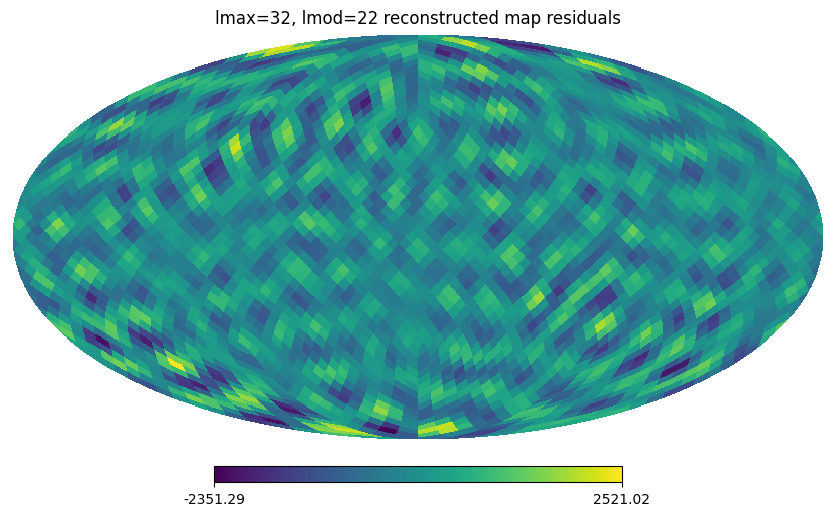

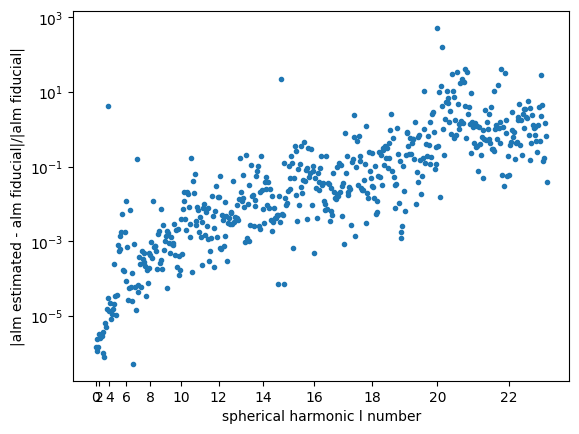

In [7]:
# Noisy case.
PL.compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_lowl_noisy, ylm_mat=ylm_mat)

In [8]:
# Now incorporate some missing-modes modelling.
def calc_basic_unmodelled_mode_matrix(lmod, lmax, nside, foreground_power_spec, beam_mat):
    """
    Calculate the unmodelled mode matrix for the trivial observation strategy and
    no binning of timeseries data.
    """
    npix = hp.nside2npix(nside)
    vectors = hp.pix2vec(nside, ipix=list(range(npix)))
    vectors = np.array(vectors).T
    vector_difference = np.einsum("pi,qi->pq", vectors, vectors)

    val = np.sum([((2*l+1)/(4*np.pi)) * eval_legendre(l, vector_difference) * foreground_power_spec[l] * beam_mat[l,l]**2 for l in range(lmod+1, lmax)], axis=0)
    return val

beam_mat = BF.calc_beam_matrix(nside=nside, lmax=lmod, beam_use=narrow_cosbeam)
mat_S = calc_basic_unmodelled_mode_matrix(lmod=lmod, lmax=lmax, foreground_power_spec=fg_cl, nside=nside, beam_mat=beam_mat)

# Carry out the corrected ML estimate.
mat_W_corrected = MM.calc_ml_estimator_matrix(mat_A=mat_A_lowl, mat_N=noise_covar+mat_S)
a_ml_corrected_noisefree = mat_W_corrected @ d
a_ml_corrected_noisy = mat_W_corrected @ d_noisy

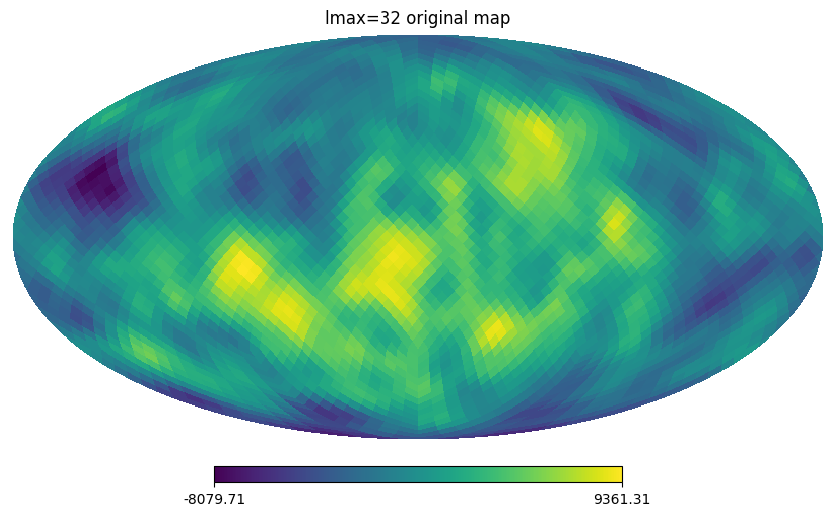

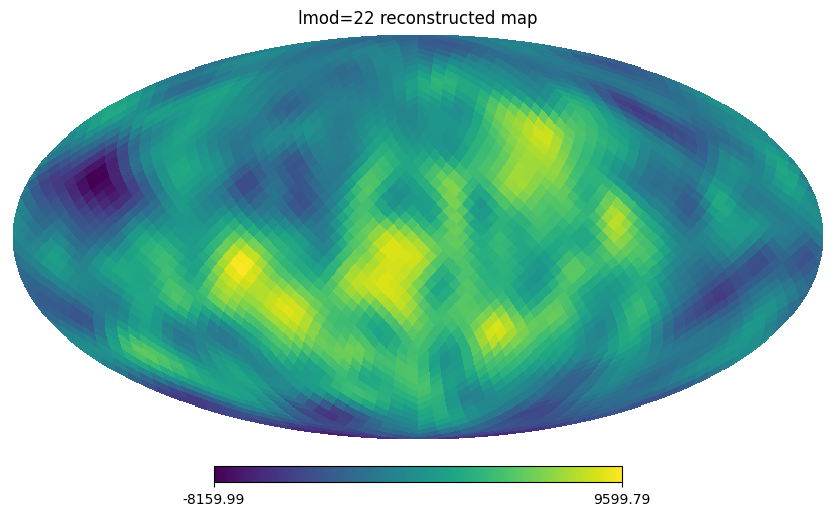

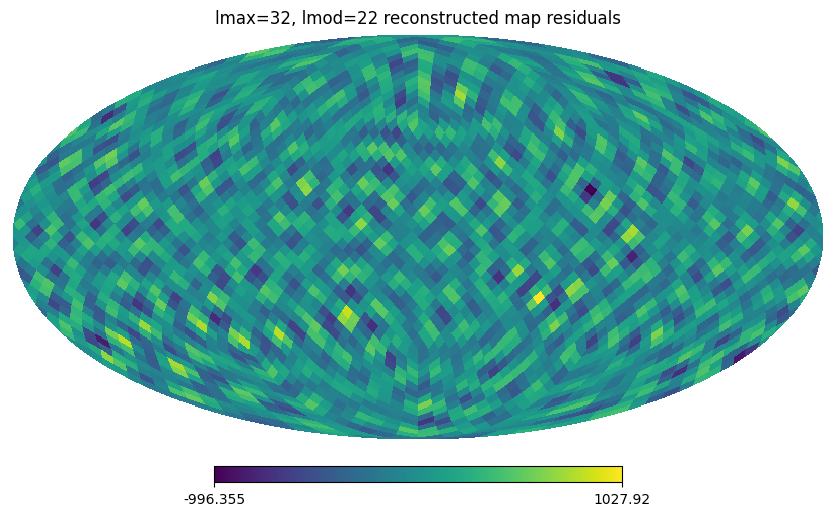

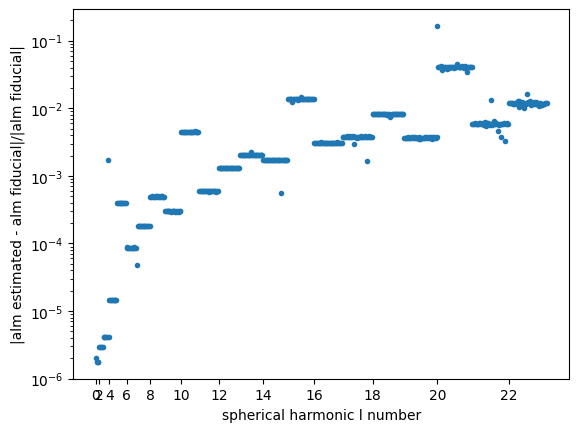

In [9]:
# Noise free case.
PL.compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_corrected_noisefree, ylm_mat=ylm_mat)

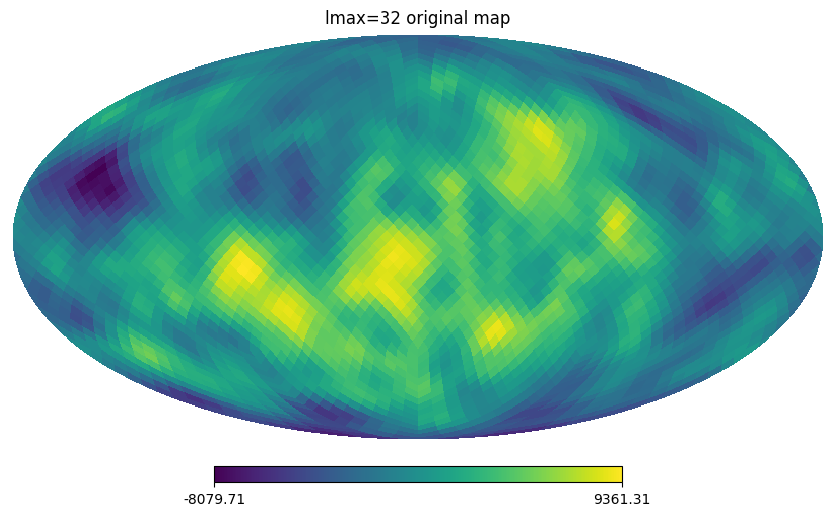

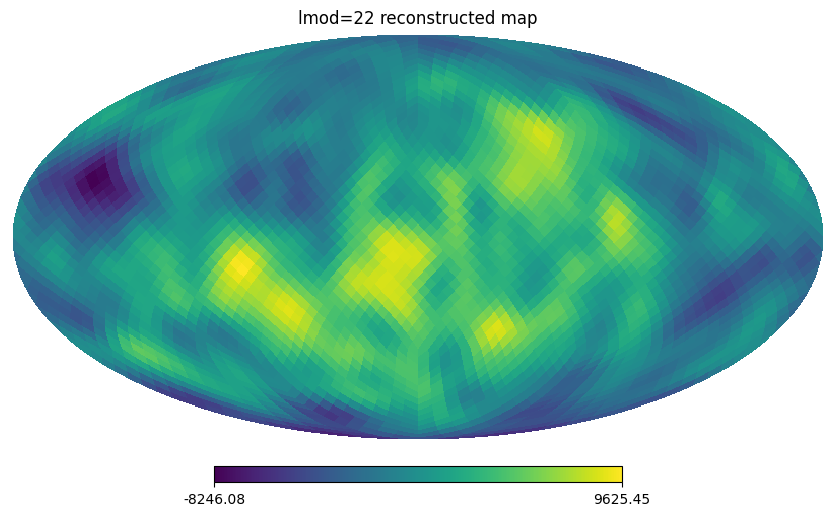

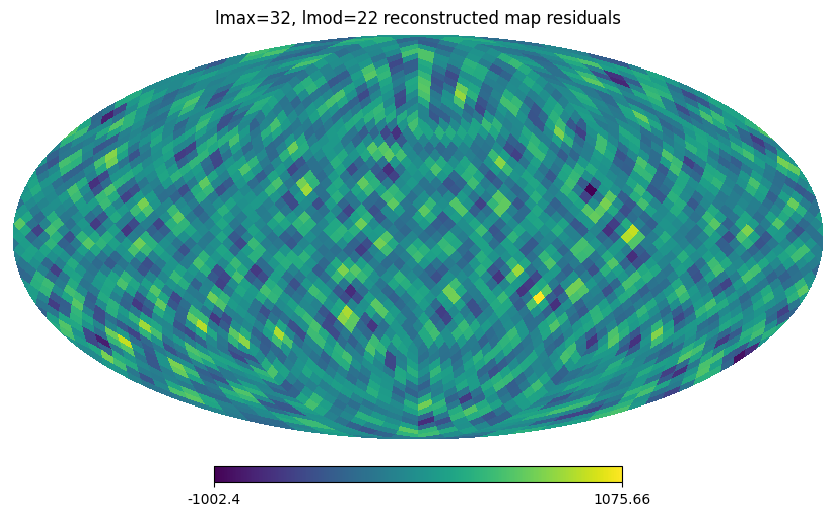

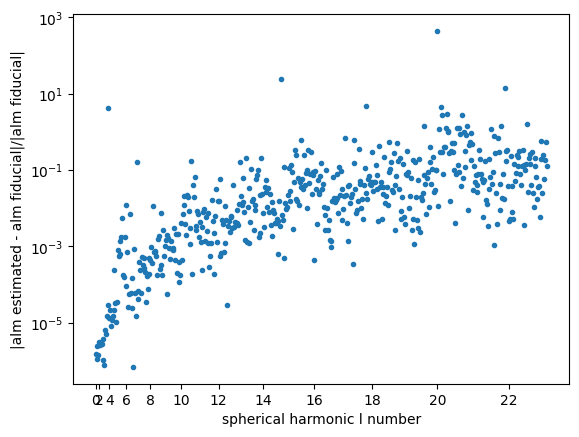

In [10]:
# Noisy case.
PL.compare_estimate_to_reality(a_reality=fg_gauss_alm, a_estimate=a_ml_corrected_noisy, ylm_mat=ylm_mat)

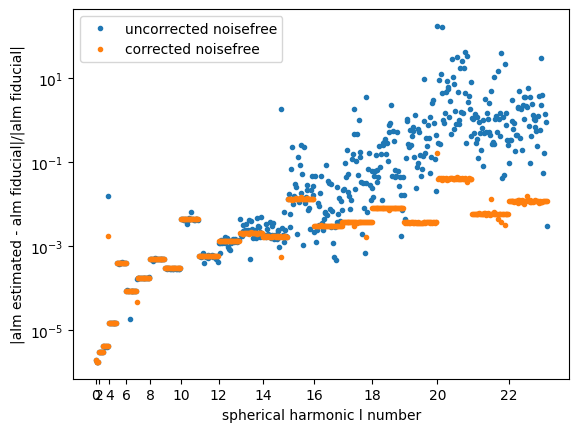

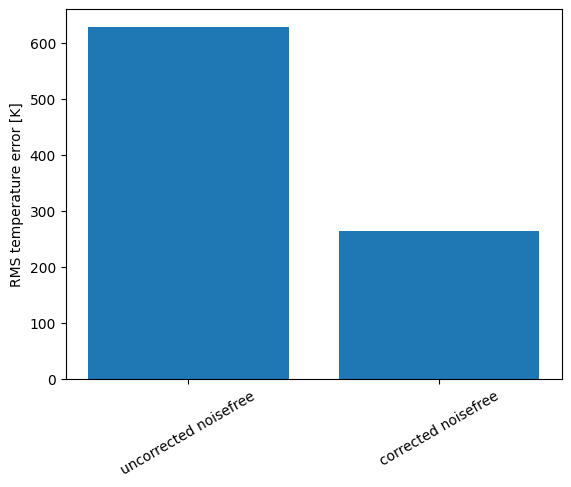

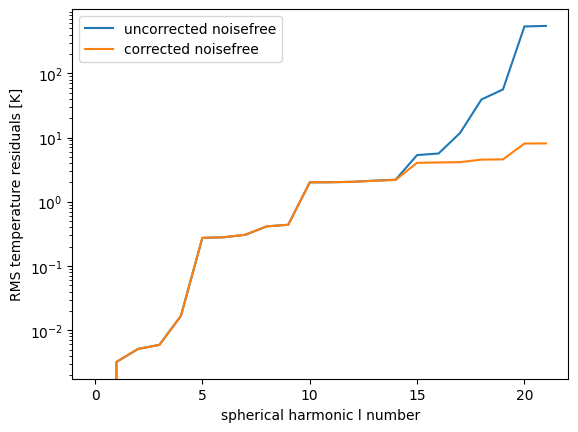

In [11]:
compare_reconstructions(fg_gauss_alm, a_ml_lowl_noisefree, a_ml_corrected_noisefree, labels=['uncorrected noisefree', 'corrected noisefree'], ylm_mat=ylm_mat)

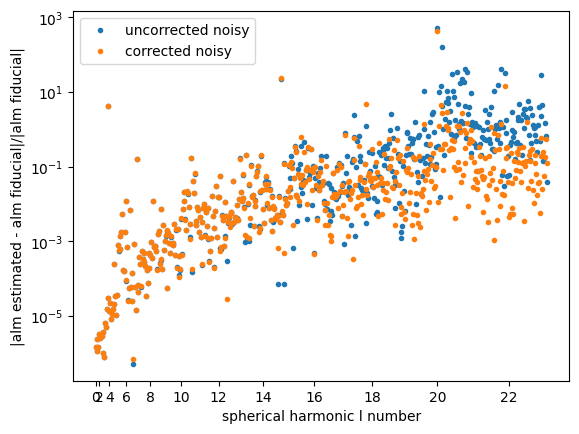

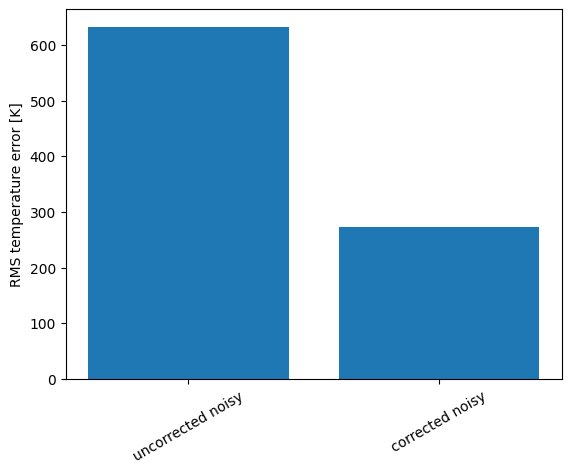

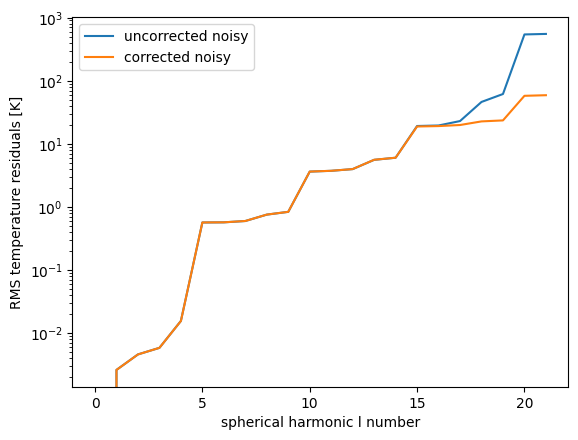

In [12]:
compare_reconstructions(fg_gauss_alm, a_ml_lowl_noisy, a_ml_corrected_noisy, labels=['uncorrected noisy', 'corrected noisy'], ylm_mat=ylm_mat)

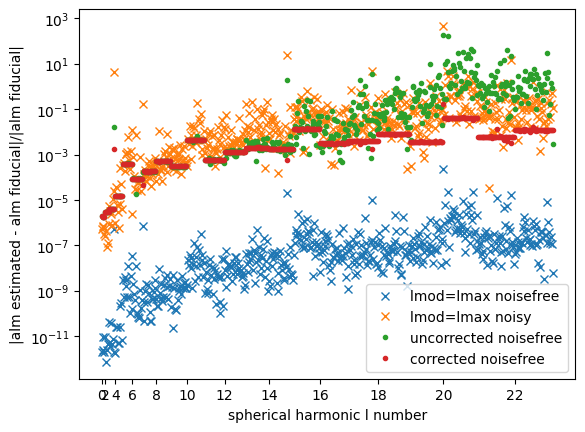

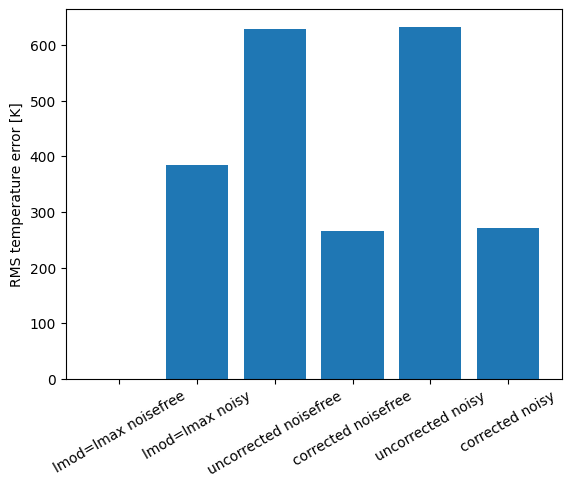

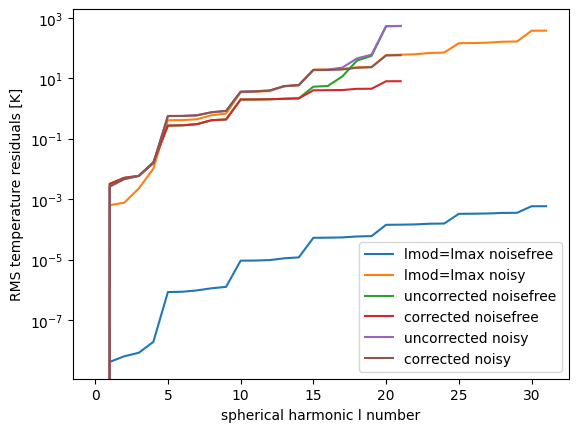

In [13]:
compare_reconstructions(fg_gauss_alm, a_ml_noisefree, a_ml_noisy, a_ml_lowl_noisefree, a_ml_corrected_noisefree, a_ml_lowl_noisy, a_ml_corrected_noisy, labels=['lmod=lmax noisefree', 'lmod=lmax noisy', 'uncorrected noisefree', 'corrected noisefree', 'uncorrected noisy', 'corrected noisy'], fmts=['x', 'x', '.', '.'], ylm_mat=ylm_mat)

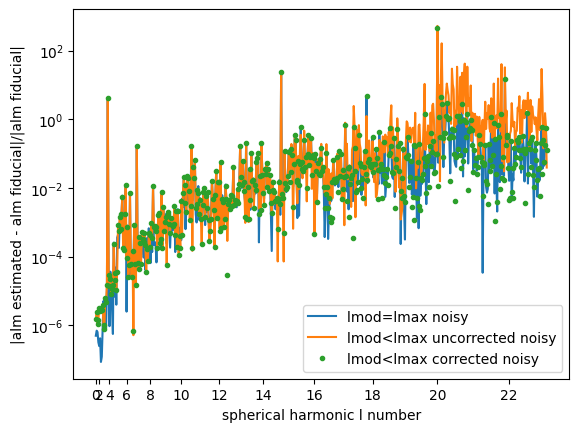

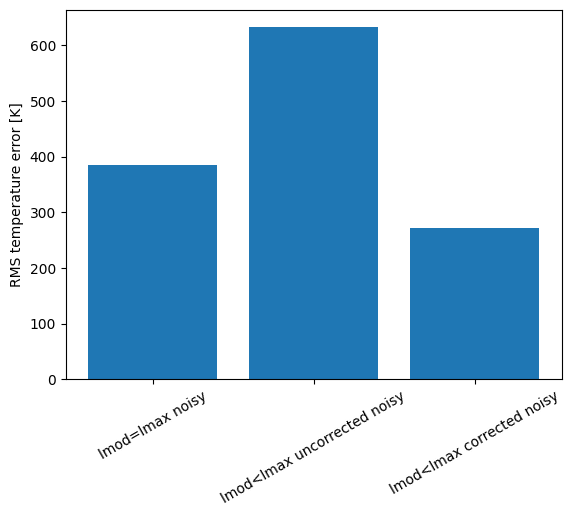

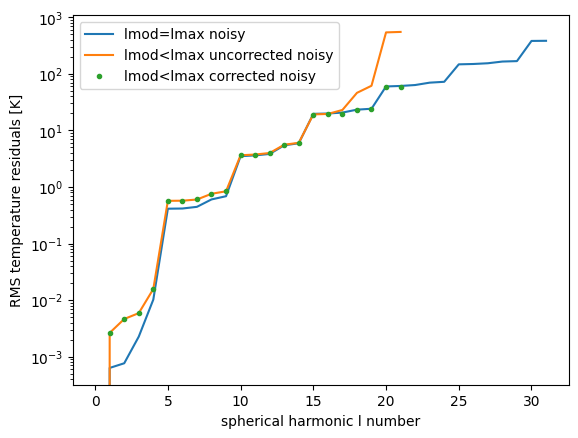

In [18]:
compare_reconstructions(fg_gauss_alm, a_ml_noisy, a_ml_lowl_noisy, a_ml_corrected_noisy, labels=['lmod=lmax noisy', 'lmod<lmax uncorrected noisy', 'lmod<lmax corrected noisy'], fmts=['-', '-', '.'], ylm_mat=ylm_mat)

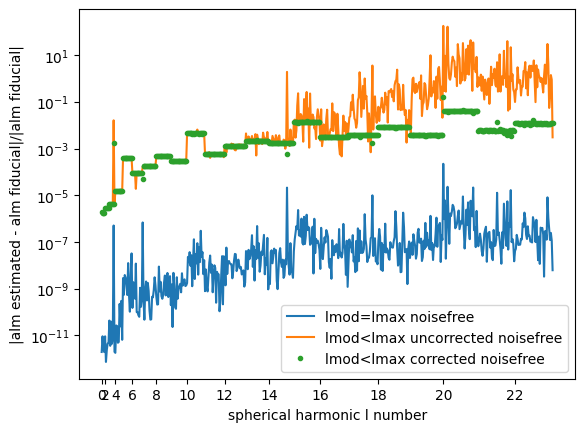

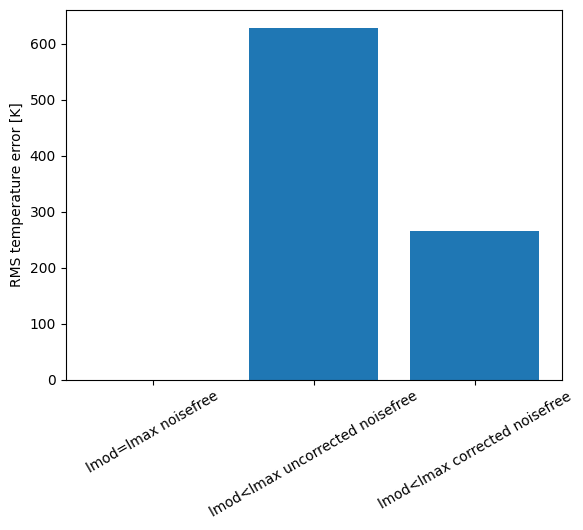

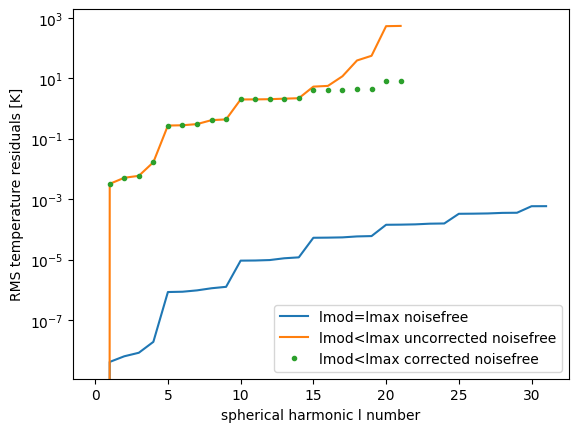

In [19]:
compare_reconstructions(fg_gauss_alm, a_ml_noisefree, a_ml_lowl_noisefree, a_ml_corrected_noisefree, labels=['lmod=lmax noisefree', 'lmod<lmax uncorrected noisefree', 'lmod<lmax corrected noisefree'], fmts=['-', '-', '.'], ylm_mat=ylm_mat)